In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [3]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
all_features_2019 = all_features_2019[
    all_features_2019["Cancelled"].eq(0) & all_features_2019["Diverted"].eq(0)
]
end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 82.1476 seconds


In [4]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    # # Remove based on the intuition that a particular day may have extremely bad weather causing many delays,
    # this guarantees overfitting to the data since this day will never happen again, it doesn't reveal a trend.
    #     "FlightDate",
    "Reporting_Airline",  # we need this to filter out the dataset later
    "Tail_Number",
    "Origin",
    "Dest",
    # "DestCityMarketID", # This is a duplication of origin and dest, which we may filter out anyway later
    # "N-NUMBER",  # Duplication of Tail_Number, we only need a single way to identify the aircraft
    # "MFR MDL CODE", # This is a joining column, duplicate of aircraft manufacturer
    # "ENG MFR MDL", # Code for engine model
    "TYPE REGISTRANT", # Corporations and LLCs
    "NAME",
    "CERTIFICATION", 
    "TYPE ENGINE",
    "STATUS CODE",
    # "MODE S CODE", These identify the aircraft uniquely, we can use tail number
    # "MODE S CODE HEX",
    # "CODE", # Duplicate of the engine model
    "MFR", # Engine manufacturer, condense this
    "MODEL", # Engine model
    "TYPE", # 5 - Fixed wing multi engine
    # "CODE_aircraft", Duplicate of the aircraft manufacturer
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND", # 0 only, we don't care about kit built aircraft
    # "faa_registration_origin", # Tracking column, may be related to registration status
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [5]:
delay_cols = [
    "DepDel15",
    "ArrDel15",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]

# Add delay columns so we can filter later
consolidated_df = all_features_2019[num_cols + cat_cols + delay_cols].copy()

# Identify problematic columns
# for col in consolidated_df.columns:
#     try:
#         consolidated_df[col].astype(float)
#     except ValueError:
#         print(f"Column {col} contains non-convertible values.")

cols_to_convert = [
    "YEAR MFR",
    "TYPE REGISTRANT",
    "TYPE",
    "TYPE-ENG",
    "BUILD-CERT-IND",
]

for col in cols_to_convert:
    try:
        consolidated_df[col] = pd.to_numeric(
            consolidated_df[col].str.strip(), errors="coerce"
        )
    except:
        print(col, "isn't a string")
        consolidated_df[col] = consolidated_df[col].astype("float")

# Clean up some of the weird, non-commercial aircraft registrations
consolidated_df = consolidated_df[
    (  # 7 or 3
        consolidated_df["TYPE REGISTRANT"].eq(7)
        | consolidated_df["TYPE REGISTRANT"].eq(3)
    )
    & (  # 4 or 5
        consolidated_df["TYPE"].eq(4) | consolidated_df["TYPE"].eq(5)
    )  # 4 or 5
    & (consolidated_df["TYPE-ENG"].eq(4) | consolidated_df["TYPE-ENG"].eq(5))
    & consolidated_df["BUILD-CERT-IND"].eq(0)  # 0 only
]

print(consolidated_df.value_counts("TYPE REGISTRANT"))

consolidated_df
# 6997303 rows × 44 columns

TYPE-ENG isn't a string
BUILD-CERT-IND isn't a string
TYPE REGISTRANT
3.0    6831815
7.0     165488
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,DepDel15,ArrDel15,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,"San Luis Obispo, CA",San Francisco International,"San Francisco, CA",0,0,0,0,0,0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,"Houston, TX",Northwest Arkansas National,"Fayetteville, AR",0,0,0,0,0,0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,"Springfield, MO",George Bush Intercontinental/Houston,"Houston, TX",0,0,0,0,0,0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,"Williston, ND",Denver International,"Denver, CO",0,0,0,0,0,0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,"Milwaukee, WI",Denver International,"Denver, CO",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,"Atlanta, GA",LaGuardia,"New York, NY",0,0,0,0,0,0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,"Orlando, FL",Minneapolis-St Paul International,"Minneapolis, MN",1,1,0,0,0,0,23
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,"Minneapolis, MN",Orlando International,"Orlando, FL",0,1,0,0,36,0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,"Washington, DC",Salt Lake City International,"Salt Lake City, UT",0,0,0,0,0,0,0


In [6]:
# BOEING                            2831659
# BOMBARDIER INC                    1262314
# AIRBUS                            1109980
# EMBRAER                            545175
# AIRBUS INDUSTRIE                   544195
# EMBRAER S A                        502448
# MCDONNELL DOUGLAS AIRCRAFT CO      103413
# EMBRAER-EMPRESA BRASILEIRA DE       83212
# MCDONNELL DOUGLAS                   64522
# AIRBUS SAS                          35971
# MCDONNELL DOUGLAS CORPORATION       25896
# C SERIES AIRCRAFT LTD PTNRSP         9258
# AIRBUS CANADA LTD PTNRSP             6573
# CANADAIR                             1948
# GULFSTREAM AEROSPACE CORP             229
# PILATUS AIRCRAFT LTD                   76
# DASSAULT                               75
# GULFSTREAM AEROSPACE                   72
# CESSNA                                 70

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"]
    .replace(r".*AIRBUS.*", "AIRBUS", regex=True)
    .replace(r".*EMBRAER.*", "EMBRAER", regex=True)
    .replace(r".*MCDONNELL DOUGLAS.*", "MCDONNELL DOUGLAS", regex=True)
    .replace(r".*YABORA.*", "YABORA", regex=True)
)

mfr_aircraft_replacements = {
    "C SERIES AIRCRAFT LTD PTNRSP": "other",
    "CANADAIR": "other",
    "GULFSTREAM AEROSPACE CORP": "other",
    "PILATUS AIRCRAFT LTD": "other",
    "DASSAULT": "other",
    "GULFSTREAM AEROSPACE": "other",
    "CESSNA": "other",
}

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"].str.strip().replace(mfr_aircraft_replacements)
)

consolidated_df.value_counts("MFR_aircraft")

MFR_aircraft
BOEING               2788233
AIRBUS               1675977
BOMBARDIER INC       1229884
EMBRAER              1099758
MCDONNELL DOUGLAS     191941
other                  11510
Name: count, dtype: int64

In [7]:
# CERTIFICATION
# 1T            7086132
# 41              10924
# 1N              10000
# 1                8931
# 1A               4097
# 410              2977
# 40               2397
# 4103             1482
# 1C                 76
# 1NU                70

certification_replacements = {
    "41": "other",
    "1N": "other",
    "1": "other",
    "1A": "other",
    "410": "other",
    "40": "other",
    "4103": "other",
    "1C": "other",
    "1NU": "other",
}

consolidated_df["CERTIFICATION"] = (
    consolidated_df["CERTIFICATION"].str.strip().replace(certification_replacements)
)

consolidated_df.value_counts("CERTIFICATION")

CERTIFICATION
1T       6956983
other      40320
Name: count, dtype: int64

In [8]:
# STATUS CODE
# V     7087375
# 25      31022
# 26       5074
# 28       2099
# 27       1516

status_code_replacements = {
    "25": "other",
    "26": "other",
    "28": "other",
    "27": "other",
}

consolidated_df["STATUS CODE"] = (
    consolidated_df["STATUS CODE"].str.strip().replace(status_code_replacements)
)

consolidated_df.value_counts("STATUS CODE")

STATUS CODE
V        6958080
other      39223
Name: count, dtype: int64

In [9]:
# MFR
# GE            2195782
# CFM INTL      2055793
# CFM INTL.     1165502
# IAE            960007
# ROLLS-ROYC     421279
# ROLLS DEUT      19537
# ROLLS-ROY          10
# P & W          287551
# P&W             20128
# P&W CANADA         70
# IVCHENKO         1276
# WILLIAMS           76
# HONEYWELL          75

mfr_replacements = {
    "CFM INTL.": "CFM INTL",
    "ROLLS-ROYC": "ROLLS-ROYCE",
    "ROLLS DEUT": "ROLLS-ROYCE",
    "ROLLS-ROY": "ROLLS-ROYCE",
    "P&W": "P & W",
    "P&W CANADA": "P & W",
    "IVCHENKO": "other",
    "WILLIAMS": "other",
    "HONEYWELL": "other",
}

consolidated_df["MFR"] = consolidated_df["MFR"].str.strip().replace(mfr_replacements)

consolidated_df.value_counts("MFR")

MFR
CFM INTL       3172698
GE             2142370
IAE             946452
ROLLS-ROYCE     428975
P & W           305393
other             1415
Name: count, dtype: int64

In [11]:
# Checkpoint

# consolidated_df.to_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

# consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

In [12]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND",
    #
    # Labels only, duplicates of the airport coordinates, also Origin/Dest
    # "Origin_DISPLAY_AIRPORT_NAME",
    # "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    # "Dest_DISPLAY_AIRPORT_NAME",
    # "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
    #
    # Only concerned with CarrierDelay for this round
    # "DepDel15",
    # "ArrDel15",
    # "CarrierDelay",
    # "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

In [13]:
# Only concerned with CarrierDelay for this round
united_df = consolidated_df[num_cols + cat_cols + ["CarrierDelay"]].copy()

united_df = united_df[united_df["Reporting_Airline"].eq("UA")]

# Convert this to "delayed"
united_df["delayed"] = united_df["CarrierDelay"].gt(15)
united_df = united_df.drop("CarrierDelay", axis=1)

# Drop NaNs
united_df = united_df.dropna(how="any", axis="index")

# Drop any features that have all identical values
nunique = united_df.nunique()
united_df = united_df.drop(nunique[nunique.eq(1)].index, axis=1)

print(united_df.columns)
print(united_df.value_counts("delayed"))
# delayed
# False    592267
# True      28434

united_df
# 620701 rows × 31 columns

Index(['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
       'CRSArrTime', 'CRSElapsedTime', 'Distance', 'DistanceGroup', 'YEAR MFR',
       'HORSEPOWER', 'THRUST', 'NO-SEATS', 'Origin_LATITUDE',
       'Origin_LONGITUDE', 'Dest_LATITUDE', 'Dest_LONGITUDE', 'Tail_Number',
       'Origin', 'Dest', 'NAME', 'CERTIFICATION', 'TYPE ENGINE', 'STATUS CODE',
       'MFR', 'MODEL', 'TYPE', 'MFR_aircraft', 'MODEL_aircraft', 'TYPE-ENG',
       'delayed'],
      dtype='object')
delayed
False    592267
True      28434
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG,delayed
25272175,1,1,22,2,1140,1700,200,1379,6,2000.0,...,1T,5,V,ROLLS-ROYCE,RB-211 SERIES,5.0,BOEING,757-224,5.0,False
25272176,1,1,22,2,1204,1520,136,854,4,2013.0,...,1T,5,V,CFM INTL,CFM56-7B27E,5.0,BOEING,737-924ER,5.0,False
25272177,1,1,22,2,1606,1849,163,937,4,2012.0,...,1T,5,V,CFM INTL,CFM56-7B26E,5.0,BOEING,737-924ER,5.0,False
25272178,1,1,22,2,2230,2329,59,182,1,2001.0,...,1T,5,V,IAE,V2500SERIES,4.0,AIRBUS,A320-232,5.0,False
25272179,1,1,22,2,1300,1634,394,2565,11,1996.0,...,1T,5,V,ROLLS-ROYCE,RB-211 SERIES,5.0,BOEING,757-224,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32219998,4,12,28,6,0634,0956,142,909,4,2002.0,...,1T,5,V,IAE,V2500SERIES,4.0,AIRBUS,A320-232,5.0,False
32219999,4,12,28,6,0900,1055,175,871,4,1998.0,...,1T,4,V,IAE,V2500SERIES,4.0,AIRBUS,A319-131,4.0,False
32220000,4,12,28,6,1715,1905,170,967,4,2009.0,...,1T,5,V,CFM INTL,CFM56-7B26/3,5.0,BOEING,737-924ER,5.0,False
32220001,4,12,28,6,1702,1845,103,447,2,1998.0,...,1T,4,V,IAE,V2500SERIES,4.0,AIRBUS,A319-131,4.0,False


In [14]:
# Define features one last time now that the identical values have been removed

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Tail_Number",
    "Origin",
    "Dest",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
]

In [15]:
# Checkpoint

# weather_df.to_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

# weather_df = pd.read_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

start_time = time.time()

X = united_df.drop("delayed", axis=1)
y = united_df["delayed"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        # ("cat", OneHotEncoder(), cat_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 3.7862 seconds


In [17]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 0.1575 seconds


In [18]:
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

X_res.shape, y_res.shape
# ((947732, 30), (947732,))

Elapsed time: 1.7057 seconds


((947732, 30), (947732,))

In [19]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))

sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

sorted_features

# ('STATUS CODE', -0.1936464635931106),
#  ('CRSDepTime', 0.05396802869037995),
#  ('MFR_aircraft', 0.0529681965594275),
#  ('CRSElapsedTime', -0.04540196665369606),
#  ('TYPE', 0.040896942813453005),
#  ('DistanceGroup', 0.03848265204906631),

[('STATUS CODE', -0.1936464635931106),
 ('CRSDepTime', 0.05396802869037995),
 ('MFR_aircraft', 0.0529681965594275),
 ('CRSElapsedTime', -0.04540196665369606),
 ('TYPE', 0.040896942813453005),
 ('DistanceGroup', 0.03848265204906631),
 ('Quarter', -0.03476610862584911),
 ('YEAR MFR', -0.034671371241669656),
 ('Origin_LATITUDE', 0.03442328757950357),
 ('THRUST', 0.032735873937804305),
 ('CERTIFICATION', -0.028906244114130026),
 ('MFR', 0.026363036496624127),
 ('Distance', 0.020023572574747177),
 ('HORSEPOWER', 0.01921474423892837),
 ('Dest_LATITUDE', -0.015953463998685777),
 ('Origin_LONGITUDE', 0.01459357461807737),
 ('Month', 0.013455378648415778),
 ('Dest_LONGITUDE', -0.012891445544523638),
 ('DayOfWeek', 0.01203980334076373),
 ('MODEL_aircraft', 0.007216394583382619),
 ('DayofMonth', 0.006353185576827445),
 ('NO-SEATS', -0.006149833896742485),
 ('NAME', 0.00608861571754688),
 ('CRSArrTime', 0.005481376845608844),
 ('MODEL', -0.0019933258463085365),
 ('TYPE-ENG', 0.00019685191709334119

In [20]:
from sklearn.linear_model import Lasso

start_time = time.time()

lasso = Lasso(alpha=0.1)
lasso.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

important_features = np.nonzero(lasso.coef_)[0]
important_feature_names = [feature_names[i] for i in important_features]


end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

important_feature_names  # :(
# ['Tail_Number', 'MODEL']

Elapsed time: 0.7842 seconds


['Tail_Number', 'MODEL']

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def fit_grid_search_logistic_regression(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        LogisticRegression(solver="saga", max_iter=1000),
        param_grid={},
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_logistic_regression(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..................................., score=0.568 total time=14.2min
[CV 2/5] END ..................................., score=0.566 total time=14.2min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..................................., score=0.568 total time=14.2min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..................................., score=0.567 total time=14.3min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..................................., score=0.568 total time=14.3min
Elapsed time: 1643.1736 seconds


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
# Checkpoint

LOGISTIC_REGRESSION_MODEL = "16_UA_carrier_delays_logistic_regression.pkl"

with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            # "learning_rate": [0.1],  # , 0.2, 0.3],
            # "max_depth": [10],  # [5, 7, 10],
            # "n_estimators": [150],  # , 250, 500],
            # "subsample": [0.7],  # [0.6, 0.7, 0.8],
            # "colsample_bytree": [0.7],  # [0.6, 0.7, 0.8],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint

XGBOOST_MODEL = "16_UA_carrier_delays_xgboost.pkl"

with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def fit_grid_search_random_forest(fit_X_train, fit_y_train):
    rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid={
            "n_estimators": [100],  # [50, 100, 150],
            "max_depth": [None],  # , 10, 20, 30],
            "min_samples_split": [2],  #  5, 10],
            "min_samples_leaf": [1],  #  2, 4],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_random_forest(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint

RANDOM_FOREST_MODEL = "16_UA_carrier_delays_random_forest.pkl"

with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def fit_grid_search_svm(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=SVC(),
        param_grid={
            # "C": [0.1, 1, 10],
            # "kernel": ["linear", "rbf"],
            # "gamma": ["auto", "scale"],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best SVM parameters: ", grid_search.best_params_)
    print("Best SVM score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_svm(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint

SVM_MODEL = "16_UA_carrier_delays_svm.pkl"

with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=HistGradientBoostingClassifier(),
        param_grid={
            "learning_rate": [0.1],  # [0.01, 0.1, 0.5],
            "max_iter": [100],  # [50, 100, 200],
            "max_depth": [None],  # [None, 10, 20],
            "min_samples_leaf": [40],  # [20, 40, 60],
            "l2_regularization": [0],  # [0.0, 1.0, 2.0]
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best HistGradientBoosting parameters: ", grid_search.best_params_)
    print("Best HistGradientBoosting score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint

GRADIENT_BOOST_MODEL = "16_UA_carrier_delays_gradient_boost.pkl"

with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.metrics import make_scorer, fbeta_score


f_score_half = make_scorer(fbeta_score, beta=0.5)
f_score_one = make_scorer(fbeta_score, beta=1)
f_score_two = make_scorer(fbeta_score, beta=2)

# {
#     "f_score_half": f_score_half,
#     "f_score_one": f_score_one,
#     "f_score_two": f_score_two,
# },
# refit=False,

# For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit
# an estimator with the best parameter setting on the whole data and make the best_* attributes
# available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

# Model Evaluation

In [23]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

# y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.5738454997039972

[[70004 48397]
 [ 2546  3194]]


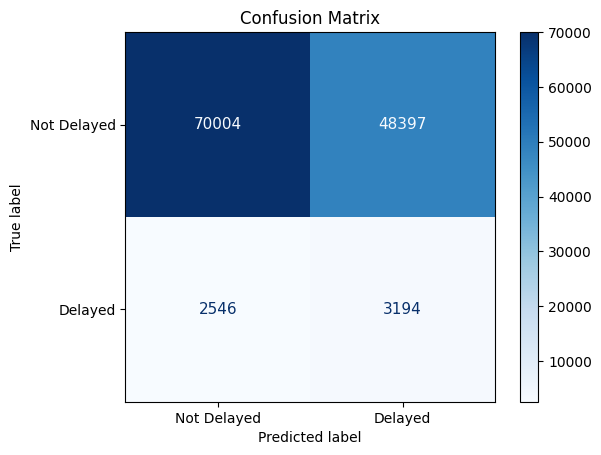

In [33]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

cmd = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
)

cmd.plot(cmap="Blues")
plt.title("Confusion Matrix")

ax = plt.gca()
for i in range(len(cm)):
    for j in range(len(cm[i])):
        text = ax.texts[i * len(cm) + j]
        text.set_text(str(cm[i][j]))
        text.set_size(11)

plt.show()

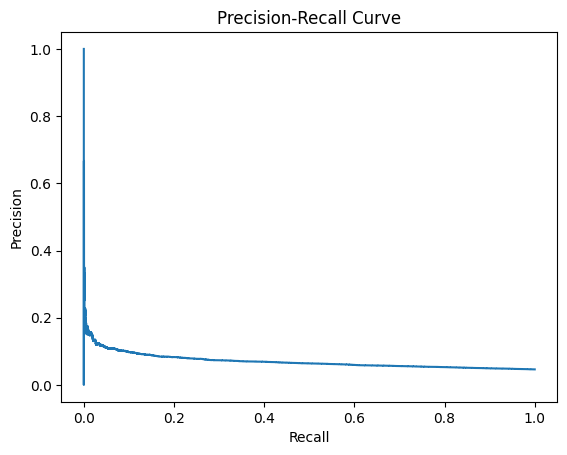

In [25]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


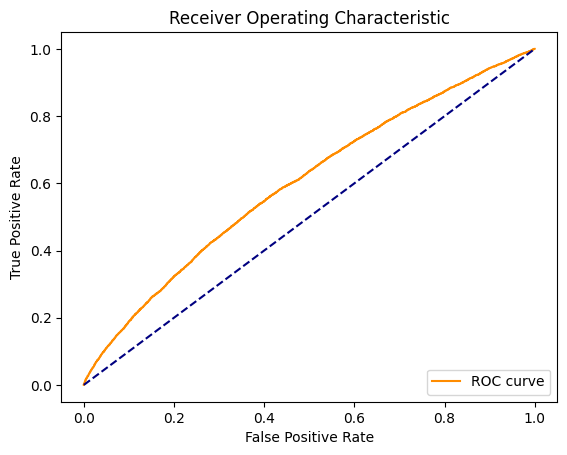

In [26]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [29]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric")),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title="Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart

alt.LayerChart(...)